# ROMS-Tools test data

In [1]:
import pooch
import xarray as xr

In [2]:
pup_test_data = pooch.create(
    # Use the default cache folder for the operating system
    path=pooch.os_cache("C-Star"),
    base_url="https://github.com/CWorthy-ocean/roms-tools-test-data/raw/main/",
    # The registry specifies the files that can be fetched
    registry={
        "GLORYS_NA_2012.nc": "b862add892f5d6e0d670c8f7fa698f4af5290ac87077ca812a6795e120d0ca8c",
        "ERA5_NA_2012.nc": "d07fa7450869dfd3aec54411777a5f7de3cb3ec21492eec36f4980e220c51757",
        "TPXO_global_test_data.nc": "457bfe87a7b247ec6e04e3c7d3e741ccf223020c41593f8ae33a14f2b5255e60",
        "CESM_BGC_2012.nc": "e374d5df3c1be742d564fd26fd861c2d40af73be50a432c51d258171d5638eb6",
        "CESM_BGC_SURFACE_2012.nc": "3c4d156adca97909d0fac36bf50b99583ab37d8020d7a3e8511e92abf2331b38"
    },
)

In [3]:
fname_glorys = pup_test_data.fetch("GLORYS_NA_2012.nc")
fname_tpxo = pup_test_data.fetch("TPXO_global_test_data.nc")
fname_era5 = pup_test_data.fetch("ERA5_NA_2012.nc")
fname_cesm_interior = pup_test_data.fetch("CESM_BGC_2012.nc")
fname_cesm_surface = pup_test_data.fetch("CESM_BGC_SURFACE_2012.nc")

In [4]:
from roms_tools import Grid, InitialConditions, TidalForcing, SurfaceForcing, BoundaryForcing

In [5]:
from datetime import datetime
start_time = datetime(2012, 1, 1, 12, 0)
end_time = datetime(2012, 12, 31, 12, 0)

## Grid

In [6]:
%%time
grid = Grid(
    nx=9, ny=9, size_x=400, size_y=400, center_lon=-5, center_lat=60, rot=10, N=3
)

CPU times: user 391 ms, sys: 217 ms, total: 608 ms
Wall time: 1.65 s


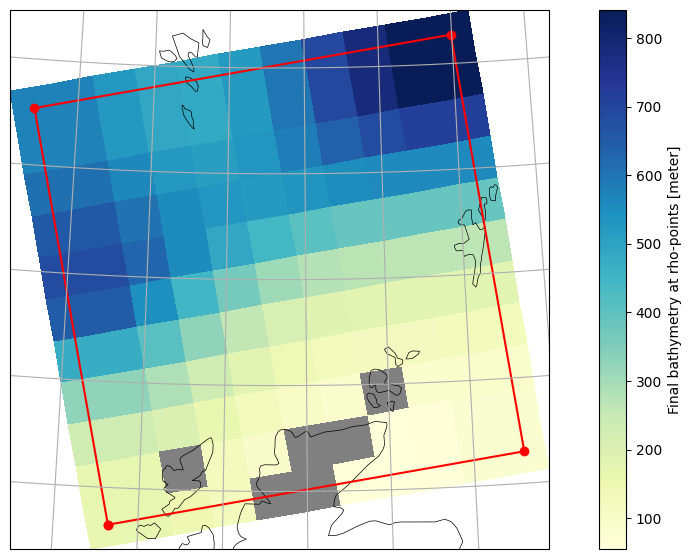

In [7]:
grid.plot(bathymetry=True)

In [8]:
# grid.to_yaml()
# grid.save()

## Initial Conditions

In [9]:
ds = xr.open_dataset(fname_glorys)

In [10]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": fname_glorys},
    bgc_source={"name": "CESM_REGRIDDED", "path": fname_cesm_interior, "climatology": False},
    use_dask=False
)

CPU times: user 27min 47s, sys: 2.74 s, total: 27min 50s
Wall time: 16.8 s


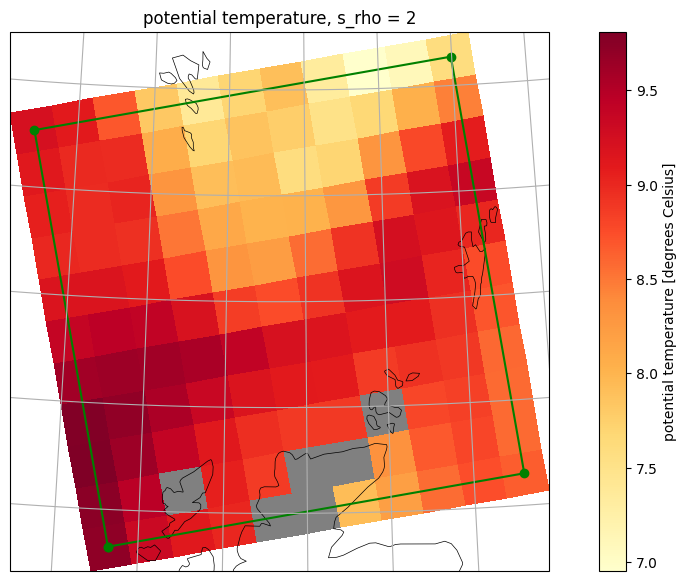

In [11]:
initial_conditions.plot("temp", s=-1)

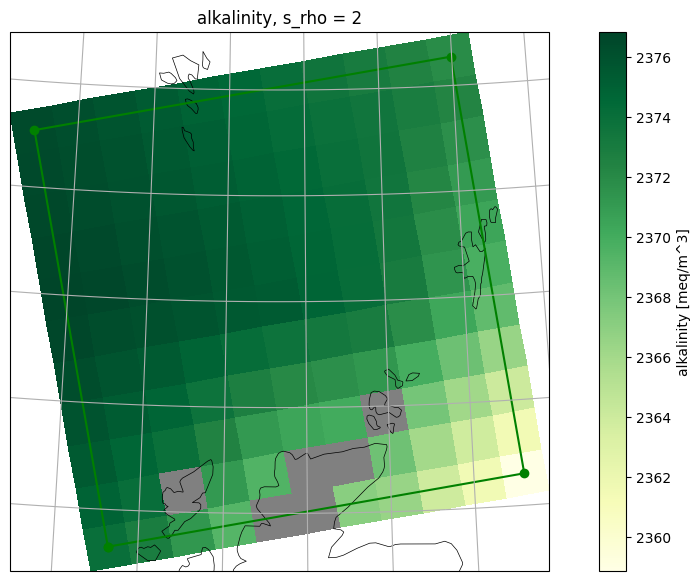

In [12]:
initial_conditions.plot("ALK", s=-1)

In [13]:
# initial_conditions.to_yaml()
# initial_conditions.save()

## Tidal Forcing

In [14]:
%%time
tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": fname_tpxo},
    ntides=2,
    use_dask=False
)

CPU times: user 1min 17s, sys: 40.5 ms, total: 1min 17s
Wall time: 507 ms


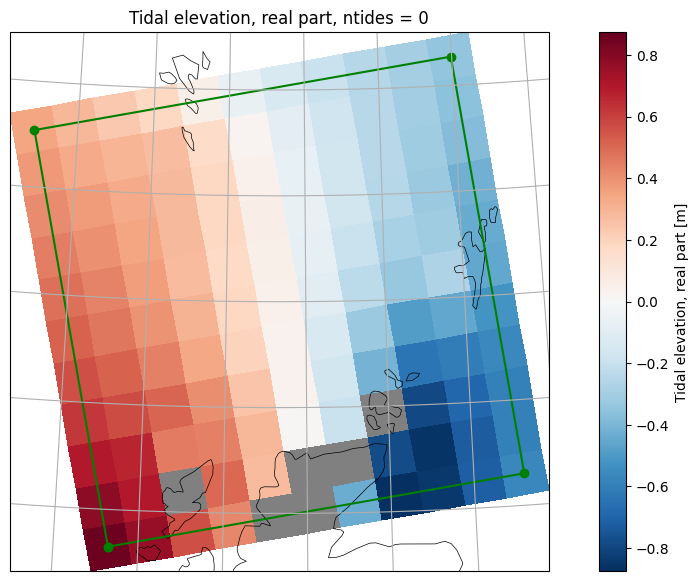

In [15]:
tidal_forcing.plot("ssh_Re", ntides=0)

In [16]:
# tidal_forcing.to_yaml()
# tidal_forcing.save()

## Surface Forcing

In [17]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": fname_era5},
    use_dask=False
)

CPU times: user 1min 35s, sys: 28.3 ms, total: 1min 35s
Wall time: 477 ms


In [18]:
surface_forcing.ds

<xarray.Dataset> Size: 7kB
Dimensions:   (time: 2, eta_rho: 11, xi_rho: 11)
Coordinates:
    abs_time  (time) datetime64[ns] 16B 2012-01-01 2013-01-01
  * time      (time) float64 16B 4.383e+03 4.749e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 968B 12.97 11.84 ... 5.887 6.466
    vwnd      (time, eta_rho, xi_rho) float32 968B 6.73 7.232 ... -2.808 -3.239
    swrad     (time, eta_rho, xi_rho) float32 968B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwrad     (time, eta_rho, xi_rho) float32 968B 288.1 276.3 ... 242.8 247.0
    Tair      (time, eta_rho, xi_rho) float32 968B 8.206 8.113 ... 5.515 5.657
    qair      (time, eta_rho, xi_rho) float32 968B 0.005525 ... 0.004045
    rain      (time, eta_rho, xi_rho) float32 968B 0.2379 0.3784 ... 0.02062
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev143
    start_time:            2012-01-01 12:00:00
    end_time:              2012-12-31 12:00:00
    source:                ERA5
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

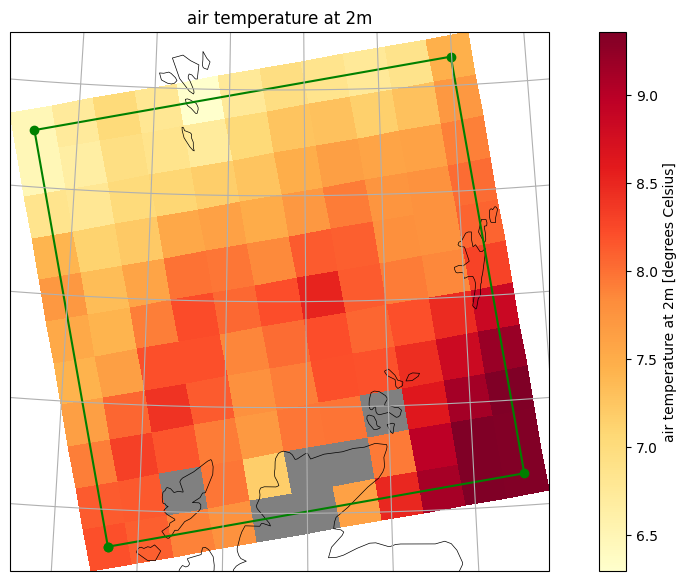

In [19]:
surface_forcing.plot("Tair", time=0)

In [20]:
# surface_forcing.to_yaml()
# surface_forcing.save()

In [21]:
%%time
surface_bgc_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": fname_cesm_surface},
    type="bgc",
    use_dask=False
)

CPU times: user 1min 21s, sys: 343 ms, total: 1min 21s
Wall time: 424 ms


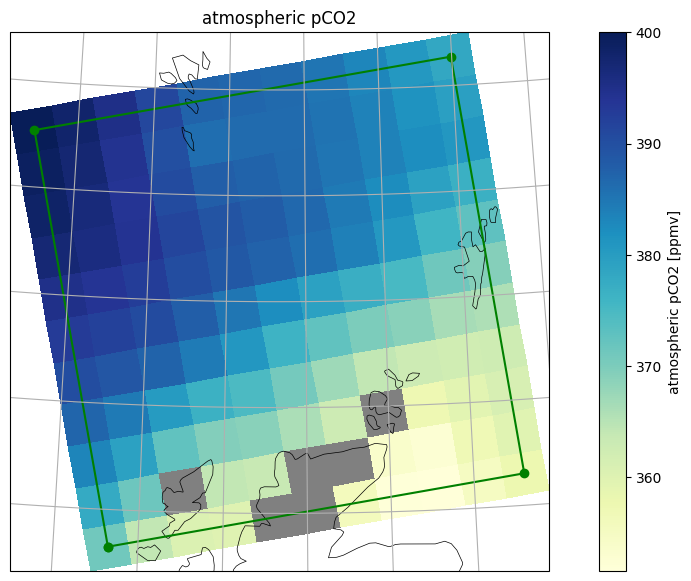

In [22]:
surface_bgc_forcing.plot("pco2_air", time=0)

In [23]:
# surface_bgc_forcing.to_yaml()
# surface_bgc_forcing.save()

## Boundary Forcing

In [24]:
%%time
boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": fname_glorys},
    use_dask=False,
)

CPU times: user 2min 56s, sys: 643 ms, total: 2min 57s
Wall time: 816 ms


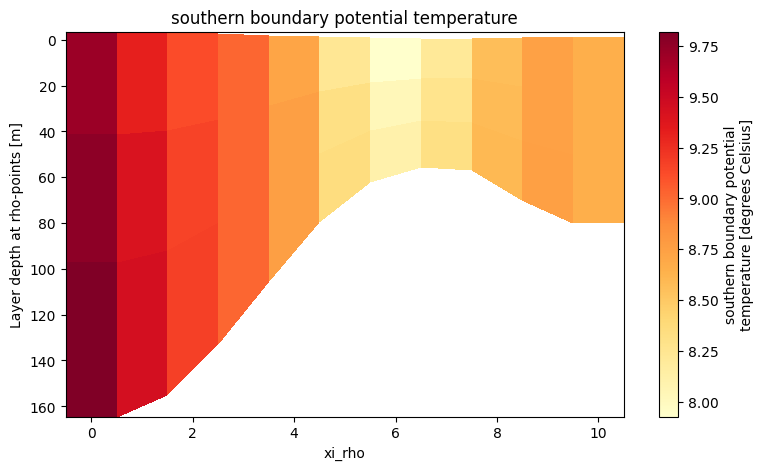

In [25]:
boundary_forcing.plot("temp_south", time=0)

In [26]:
# boundary_forcing.to_yaml()
# boundary_forcing.save()

In [27]:
ds = xr.open_dataset(fname_cesm_interior)

In [28]:
%%time
boundary_bgc_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": fname_cesm_interior},
    type="bgc",
    use_dask=False,
)

CPU times: user 54min 17s, sys: 4.95 s, total: 54min 22s
Wall time: 13.2 s


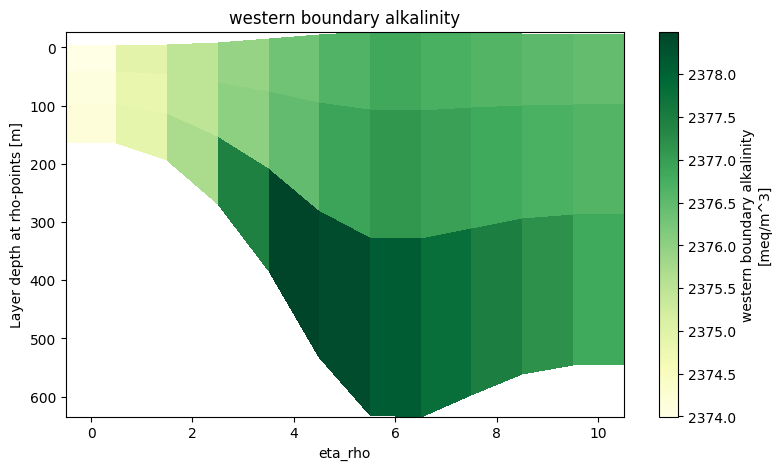

In [29]:
boundary_bgc_forcing.plot("ALK_west")

In [30]:
# boundary_bgc_forcing.to_yaml()
# boundary_bgc_forcing.save()